<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
# полдключаем библиотеку проекта
import sys
sys.path.insert(1, './../src/')
from preprocessing import *

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = os.path.join('.', '..', 'data', 'capstone_user_identification')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    '''
    Формирование DataFrame'a сессий с столбцами [site1, ..., site{session_length},
    time_diff1, ..., time_diff{session_length - 1}, timespan, unique, start, day_of_week, target]
    здесь:
    siteN -- индекс N-го сайта сессии
    time_diffN -- разница вежду посещением N-го и (N+1)-го сайтов [сек]
    timespan -- продолжительность сессии [сек]
    unique -- число уникальных сайтов в сессии
    start -- час начала сессии
    day_of_week -- день недели
    target -- id пользователя
    :param path_to_csv_files: путь к папке с .csv файлами пользователей
    :param site_freq_path: путь к .pickle файлу со словарём файлов
    :param feature_names: название столбцов формирующегося DataFrame'a
    :param session_length: длина сессии
    :param window_size: ширина окна непересекающейся части сессии
    :return: pandas.DataFrame
    '''
    if len(feature_names) != (2 * session_length - 1 + 5):
        raise ValueError('length of feature_names must be equal to 2 * session_length - 1 + 5')

    with open(site_freq_path, 'rb') as fo:
        site_freq = pickle.load(fo)

    output = []
    for path in glob(os.path.join(path_to_csv_files, '*.csv')):
        data = pd.read_csv(path)
        username, _ = os.path.splitext(os.path.basename(path))
        user_id = int(username[-4:])

        data_len = len(data)
        for i in range(0, data_len, window_size):
            last_index = min(data_len, i + session_length)
            empty_data_len = i + session_length - last_index
            sub_df = data.iloc[i:last_index]
            sites = list(sub_df.site.apply(lambda x: site_freq[x][0])) + [0 for i in range(empty_data_len)]
            timestamps = sub_df.timestamp.astype(np.datetime64)
            times = [(timestamps.iloc[i+1] - timestamps.iloc[i]).total_seconds() for i in range(len(timestamps)-1)] + \
                    [0 for i in range(empty_data_len)]
            timespan = (timestamps.max() - timestamps.min()).total_seconds()
            unique = (np.unique(sites) > 0).sum()
            start = timestamps.min().hour
            day_of_week = timestamps.min().dayofweek
            target = user_id

            output.append(sites + times + [timespan, unique, start, day_of_week, target])

    output = pd.DataFrame(output, dtype=int)
    output.columns = feature_names

    return output

**Проверим функцию на игрушечном примере.**

In [7]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                                               site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                               feature_names=feature_names, session_length=10)

Wall time: 39.7 s


In [70]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [71]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                             '150users'), 
                                                site_freq_path=os.path.join(PATH_TO_DATA, 
                                                                            'site_freq_150users.pkl'),
                                                feature_names=feature_names, session_length=10)

Wall time: 6min 30s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
columns = ['session_timespan', 
           '#unique_sites', 
           'start_hour', 
           'day_of_week', 
           'target']
new_features_10users = train_data_10users[columns]
new_features_150users = train_data_150users[columns]

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

Сохраним и полные пиклы на всякий случай

In [11]:
with open(os.path.join(PATH_TO_DATA, 
                       'features_eng_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(train_data_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'features_eng_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(train_data_150users, new_features_150users_pkl)

In [12]:
with open(os.path.join(PATH_TO_DATA, 
                       'features_eng_10users.pkl'), 'rb') as new_features_10users_pkl:
    train_data_10users = pickle.load(new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'features_eng_150users.pkl'), 'rb') as new_features_150users_pkl:
    train_data_150users = pickle.load(new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

Медианная продолжительности сессии для 10 человек 37.0


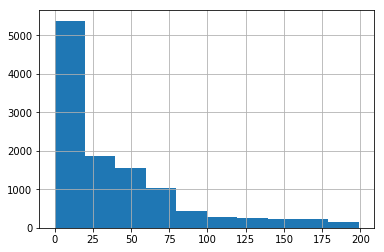

In [35]:
train_data_10users['session_timespan'][train_data_10users['session_timespan'] < 200].hist()
print('Медианная продолжительности сессии для 10 человек {}'.format(train_data_10users['session_timespan'].median()))

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

Медианный день начала сессии для 10 человек 2.0


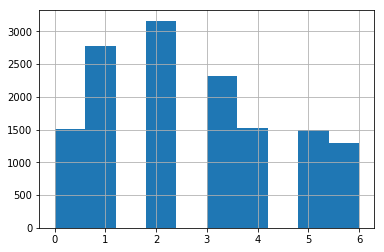

In [26]:
train_data_10users['day_of_week'].hist()
print('Медианный день начала сессии для 10 человек {}'.format(train_data_10users['day_of_week'].median()))

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

Медианный час начала сессии для 150 человек 13.0


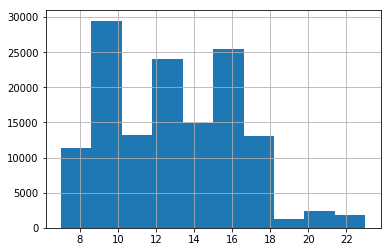

In [31]:
train_data_150users['start_hour'].hist()
print('Медианный час начала сессии для 150 человек {}'.format(train_data_150users['start_hour'].median()))

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

Медианное число уникальных сайтов в сессии для 150 человек 7.0


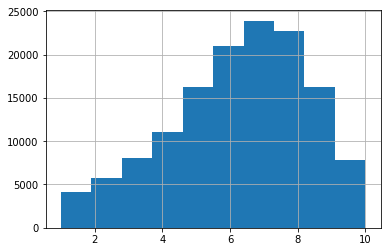

In [32]:
train_data_150users['#unique_sites'].hist()
print('Медианное число уникальных сайтов в сессии для 150 человек {}'.format(train_data_150users['#unique_sites'].median()))

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [33]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [34]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

[Text(0, 0.5, 'Количество сессий'),
 Text(0.5, 0, 'Продолжительность сессии в секундах'),
 Text(0.5, 1.0, 'Гистограмма продолжительности сессии для 10 пользователей')]

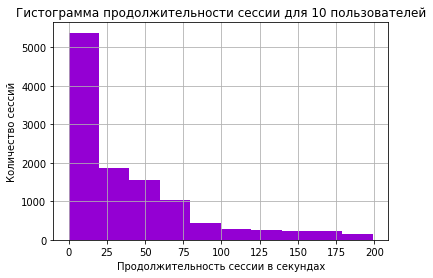

In [43]:
plot1 = train_data_10users['session_timespan'][train_data_10users['session_timespan'] < 200].hist(color='darkviolet')
plot1.set(xlabel='Продолжительность сессии в секундах', 
          ylabel='Количество сессий', 
          title='Гистограмма продолжительности сессии для 10 пользователей')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

[Text(0, 0.5, 'Количество сессий'),
 Text(0.5, 0, 'Количество уникальных сайтов'),
 Text(0.5, 1.0, 'Гистограмма количества уникальных сайтов в сессии для 10 пользователей')]

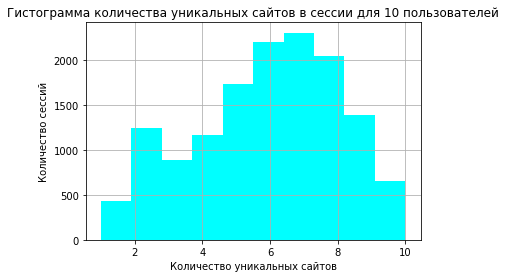

In [45]:
plot2 = train_data_10users['#unique_sites'].hist(color='aqua')
plot2.set(xlabel='Количество уникальных сайтов', 
          ylabel='Количество сессий', 
          title='Гистограмма количества уникальных сайтов в сессии для 10 пользователей')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (#unique_sites) для каждого из 10 пользователей по отдельности. Используйте subplots, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (color_dic). Подпишите оси по-русски в каждой из 10 гистограмм**

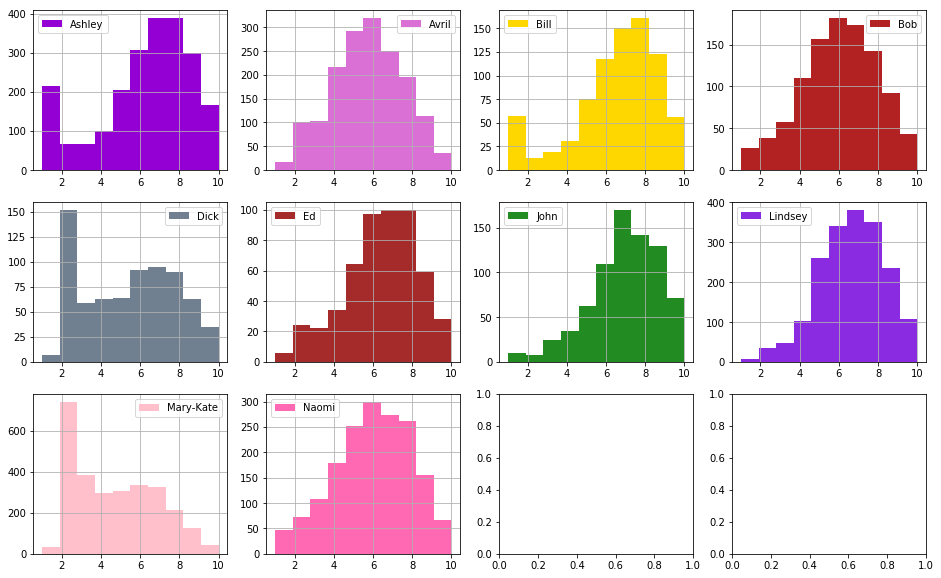

In [63]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
     sub_df['#unique_sites'].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user)
     axes[idx // 4, idx % 4].legend()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

[Text(0, 0.5, 'Количество сессий'),
 Text(0.5, 0, 'Час начала сессии'),
 Text(0.5, 1.0, 'Гистограмма часа начала сессии сессии для 10 пользователей')]

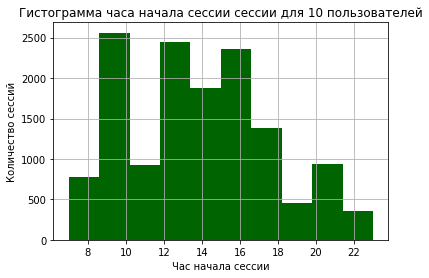

In [64]:
plot3 = train_data_10users['start_hour'].hist(color='darkgreen')
plot3.set(xlabel='Час начала сессии', 
          ylabel='Количество сессий', 
          title='Гистограмма часа начала сессии сессии для 10 пользователей')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
     ''' ВАШ КОД ЗДЕСЬ '''

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

In [ ]:
train_data_10users['day_of_week'] ''' ВАШ КОД ЗДЕСЬ '''

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
     ''' ВАШ КОД ЗДЕСЬ '''

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [ ]:
with open ''' ВАШ КОД ЗДЕСЬ '''

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [ ]:
top10_freqs = ''' ВАШ КОД ЗДЕСЬ '''
top10_sites = ''' ВАШ КОД ЗДЕСЬ '''

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

In [ ]:
sns.barplot ''' ВАШ КОД ЗДЕСЬ '''

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 